# Hack IMDb Rating
## Introduction

Welcome to the Movie Data Analysis Project! This notebook is designed to take you through a comprehensive journey of exploring, analyzing, and understanding the intricate world of movies. Our primary goal is to uncover the factors that influence a movie's success, focusing on aspects such as revenue generation and IMDB ratings.

This notebook is structured to guide you through each step of the process, from data loading and cleaning to in-depth analysis. So, let's dive in and explore the fascinating world of movies through the lens of data science!



## Research Questions

1. *What factors contribute to a movie's success, and how do they interplay?*
   - Language and its role in reaching a wider audience
   - Impact of film duration
   - The influence of release timing on ratings
   - How movie genres have evolved over time
   - The correlation between box office success and ratings
   - Geographical patterns in movie ratings 
   

2. *How does diversity and representation influence movie ratings?*
   - Gender diversity within film casts
   - The effect of ethnic diversity on a film's reception

3. *What impact do actors have on a film's rating?*
   - The role of actor types and their influence
   - Effects of actor collaborations on film ratings

4. *Does the portrayal of characters (protagonists) affect ratings?*

5. *Is there a link between real-world events and a movie's success?*
   - Analysis of movie plots in relation to real-world events
   - Comparative study of event-based movies against other genres
   - Exploration of propaganda films and their ratings impact

6. *Can we develop a predictive model for movie ratings?*
   - Utilizing identified key parameters for prediction
   - Implementing sentiment analysis of movie reviews and comments

## Additional Dataset

To enrich our analysis, we will add the IMDb ratings dataset.

By addressing these questions with  analytical methods, we aim to offer a comprehensive understanding of the factors influencing IMDb ratings.


In [1]:
#imports
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from SPARQLWrapper import SPARQLWrapper, JSON

import json


sns.set_style("whitegrid")
pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


---
# Data Pipeline


## Dataset Overview

### CMU Movie Summary Corpus

We begin by analysing data from the CMU Movie Summary Corpus. This collection includes several files:

- *character.metadata.csv:* Contains metadata information about movie characters.
- *movie.metadata.tsv:* Provides movie metadata such as title, genre, and release year.
- *name.cluster.txt:* Offers information related to name clustering.
- *plot_summaries.txt:* Contains summaries of movie plots.
- *tvtropes.cluster.txt:* Includes data on TV Tropes clustering.

### IMDb Rating Dataset

Our analysis integrates the IMDb rating dataset taken from [IMDb Datasets](https://datasets.imdbws.com). This dataset comprises two CSV files:

- *rating_id.csv:* Contains IMDb rating data.
- *name_id.csv:* Includes additional information about the movies (name, type, ...).

### Events Dataset

Supplementary data, generated by ChatGPT, is included in the analysis. This dataset captures the most significant events from 1820 to 2014 and is created using the code found in `generate_events.py`.

## Oscar Dataset

This dataset is a collection of data from The Academy Awards Database, containing the winners and nominees of the Oscars from 1927 to 2023. it is taken from [kaggle Oscars Dataset](https://www.kaggle.com/datasets/unanimad/the-oscar-award) 


#### 1. Loading CMU Data

In [2]:
#read tsv file and add headers
movie_metadata_df = pd.read_csv('data/CMU_DATA/movie.metadata.tsv', sep='\t', header=None, 
                names=['wiki_movie_id', 
                        'freebase_movie_id', 
                        'movie_name', 
                        'movie_release_date', 
                        'movie_box_office_revenue', 
                        'movie_runtime', 
                        'movie_languages', 
                        'movie_countries', 
                        'movie_genres'])

#changing the values of outliers
movie_metadata_df.loc[movie_metadata_df['movie_name'] == 'Zero Tolerance', 'movie_runtime'] = 88
movie_metadata_df.loc[movie_metadata_df['movie_name'] == 'Hunting Season', 'movie_release_date'] = '2010-12-02'

#add realase_year 
movie_metadata_df['startYear']= movie_metadata_df['movie_release_date'].str[:4]

#change movie_release_date to pandas datetime
movie_metadata_df['movie_release_date'] = pd.to_datetime(movie_metadata_df['movie_release_date'], format='%Y-%m-%d', errors='coerce')
movie_metadata_df.head()


,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,startYear
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000
2,28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988
3,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987
4,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983


In [3]:
#loading the plot summaries dataset and add headers
plot_summaries_df = pd.read_csv('data/CMU_DATA/plot_summaries.txt', sep='\t', header=None, 
                names=['wiki_movie_id', 
                        'plot_summary'])
plot_summaries_df.head()

,wiki_movie_id,plot_summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [4]:
#read text file and add headers, name.clusters.txt
name_clusters_df = pd.read_csv('data/CMU_DATA/name.clusters.txt', sep='\t', header=None, 
                names=['character_name', 
                        'freebase_character_actor_map_id'])
name_clusters_df.head()

,character_name,freebase_character_actor_map_id
0,Stuart Little,/m/0k3w9c
1,Stuart Little,/m/0k3wcx
2,Stuart Little,/m/0k3wbn
3,John Doe,/m/0jyg35
4,John Doe,/m/0k2_zn


In [5]:
#read text file and add headers, name.clusters.txt
name_clusters_df = pd.read_csv('data/CMU_DATA/name.clusters.txt', sep='\t', header=None, 
                names=['character_name', 
                        'freebase_character_actor_map_id'])
name_clusters_df.head()

,character_name,freebase_character_actor_map_id
0,Stuart Little,/m/0k3w9c
1,Stuart Little,/m/0k3wcx
2,Stuart Little,/m/0k3wbn
3,John Doe,/m/0jyg35
4,John Doe,/m/0k2_zn


In [6]:
#read text file and add headers
character_metadata_df = pd.read_csv('data/CMU_DATA/character.metadata.tsv', sep='\t', header=None, 
                names=['wiki_movie_id',
                        'freebase_movie_id',
                        'movie_release_date',
                        'character_name',
                        'actor_date_of_birth',
                        'actor_gender',
                        'actor_height',
                        'actor_ethnicity',
                        'actor_name',
                        'actor_age_at_movie_release',
                        'freebase_character_actor_map_id',
                        'freebase_character_id',
                        'freebase_actor_id'])
character_metadata_df.head()

,wiki_movie_id,freebase_movie_id,movie_release_date,character_name,actor_date_of_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [7]:
#read text file and add headers
tvtropes_clusters_df = pd.read_csv('data/CMU_DATA/tvtropes.clusters.txt', sep='\t', header=None, names=['character_type', 'data_dict'])
#transform second column to columns
tvtropes_clusters_df['data_dict'] = tvtropes_clusters_df['data_dict'].apply(json.loads)
tvtropes_clusters_df = pd.concat([tvtropes_clusters_df.drop(['data_dict'], axis=1), tvtropes_clusters_df['data_dict'].apply(pd.Series)], axis=1)
#rename columns
tvtropes_clusters_df.columns = ['character_type', 'character_name', 'movie_name', 'freebase_character_actor_map_id', 'actor_name']
tvtropes_clusters_df.head()

,character_type,character_name,movie_name,freebase_character_actor_map_id,actor_name
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader


#### 2. Loading IMDB Data

In [8]:
#load IMDB reviews
rating_id_df = pd.read_csv('data/IMDB_DATA/rating_id.tsv',  sep='\t')
name_id_df = pd.read_csv('data/IMDB_DATA/name_id.tsv',  sep='\t')
rating_df = pd.merge(rating_id_df, name_id_df, on='tconst')

#drop unnecessary columns 
rating_df.drop(['originalTitle','isAdult','endYear','runtimeMinutes','genres'], axis=1, inplace=True)
rating_df.head()

/var/folders/mh/x4l3pnxs4tz1xb2b7lxjg7600000gn/T/ipykernel_90140/75358026.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  name_id_df = pd.read_csv('data/IMDB_DATA/name_id.tsv',  sep='\t')


,tconst,averageRating,numVotes,titleType,movie_name,startYear
0,tt0000001,5.7,2007,short,Carmencita,1894
1,tt0000002,5.8,269,short,Le clown et ses chiens,1892
2,tt0000003,6.5,1911,short,Pauvre Pierrot,1892
3,tt0000004,5.5,178,short,Un bon bock,1892
4,tt0000005,6.2,2692,short,Blacksmith Scene,1893


#### 3. Loading Events Data

In [9]:
#loading the events dataset 
events = pd.read_csv('data/GENERATED_DATA/events.csv')
events.head()

,Year,Event Name,Event Description,Event Location,Event Category
0,1820,Missouri Compromise,The U.S. Congress passes the Missouri Compromi...,USA,Political Events
1,1820,Antarctic Discovery,The British explorer James Weddell discovers t...,GBR,Science and health advancement
2,1820,The Cato Street Conspiracy,An attempt to murder all the British cabinet m...,GBR,Political Events
3,1820,Death of George III,King George III of the United Kingdom passes a...,GBR,Political Events
4,1820,Establishment of Liberia,American Colonization Society purchases a smal...,LBR,Social Movements


#### 4. Merging The Movie Metadata With The IMDb Ratings

In [10]:
#merging the movie metadata with the rating data on movie name and release year
movies_metadata_ratings = pd.merge(movie_metadata_df, rating_df,  on=['movie_name', 'startYear'])
movies_metadata_ratings.head()

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,startYear,tconst,averageRating,numVotes,titleType
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,tt0228333,4.9,56920,movie
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,tt0594845,7.6,20,tvEpisode
2,28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988,tt0094806,5.6,40,movie
3,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983,tt0083949,5.9,623,movie
4,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,tt0002894,6.8,17,short


#### 5. Cleaning The Data

After inspecting of the plot_summary file in the CMU dataset, we noticed that some movie plots contains undesired words such as ({long plot}, {plot}...). These outliers can degrade our plot analysis so we proceeded to remove them. 

In [11]:
#remove any {{ }} from the plot summary text
plot_summaries_df['plot_summary'] = plot_summaries_df['plot_summary'].str.replace(r'\{\{.*?\}\}', '', regex=True)

We noticed the IMDb dataset included other types of movies, those movies are also in some cases present in the CMU dataset. Since our analysis focuses on movies we opted to only keep 'movie' tittle type movies. 

In [12]:
# printing the types of the merged data 
movies_metadata_ratings['titleType'].unique()

array(['movie', 'tvEpisode', 'short', 'tvMovie', 'video', 'tvSeries',
       'videoGame', 'tvMiniSeries', 'tvSpecial', 'tvShort'], dtype=object)

In [13]:
# keeping only movies, delete tv episodes, tv movies, video games, etc.
movies_metadata_ratings = movies_metadata_ratings[movies_metadata_ratings['titleType']=='movie']
movies_metadata_ratings.head()

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,startYear,tconst,averageRating,numVotes,titleType
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,tt0228333,4.9,56920,movie
2,28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988,tt0094806,5.6,40,movie
3,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983,tt0083949,5.9,623,movie
5,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938,tt0029852,6.8,2268,movie
6,175026,/m/017n1p,Sarah and Son,1930-01-01,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/01g6gs"": ""Black-an...",1930,tt0021335,5.4,300,movie


we noticed that the IMDb dataset contains movie ratings that have few ratings so we thought that these ratings could be biased so we removed the movies that have less than 200 votes

In [14]:
# only keep the movies with more than 200 votes on imdb ratings
movies_metadata_ratings = movies_metadata_ratings[movies_metadata_ratings['numVotes']>200]
movies_metadata_ratings.shape

(27739, 14)

Now we will filter the other datasets so that they are consistant

In [15]:
#keep movie_metadata_df only with movies that have ratings
movie_metadata_df = movie_metadata_df[movie_metadata_df['freebase_movie_id'].isin(movies_metadata_ratings['freebase_movie_id'])]
movie_metadata_df.shape

(27655, 10)

In [16]:
#keep the summaries of the selected movies 
plot_summaries_df = plot_summaries_df[plot_summaries_df['wiki_movie_id'].isin(movie_metadata_df['wiki_movie_id'])]
plot_summaries_df.shape

(20161, 2)

In [17]:
#keep movie_metadata_df only with movies that have summaries
movie_metadata_df = movie_metadata_df[movie_metadata_df['wiki_movie_id'].isin(plot_summaries_df['wiki_movie_id'])]
movie_metadata_df.shape

(20161, 10)

In [18]:
#keep movies_metadata_ratings only with movies that have summaries
movies_metadata_ratings = movies_metadata_ratings[movies_metadata_ratings['wiki_movie_id'].isin(plot_summaries_df['wiki_movie_id'])]
movies_metadata_ratings.shape

(20216, 14)

In [19]:
#keep the character_metadata_df only with movies that have summaries and ratings
character_metadata_df = character_metadata_df[character_metadata_df['wiki_movie_id'].isin(movie_metadata_df['wiki_movie_id'])]
character_metadata_df.shape

(192540, 13)

In [20]:
#keep the tvtropes_clusters_df only with movies that have summaries and ratings
tvtropes_clusters_df = tvtropes_clusters_df[tvtropes_clusters_df['freebase_character_actor_map_id'].isin(character_metadata_df['freebase_character_actor_map_id'])]
tvtropes_clusters_df.shape

(453, 5)

---
# Data Analysis

## 1- effect of language 

In [21]:
languages_df_with_ratings = movies_metadata_ratings[['wiki_movie_id', 'movie_languages', 'averageRating']]

languages_df_with_ratings['movie_languages'] = languages_df_with_ratings['movie_languages'].apply(lambda x: list(json.loads(x).values()))

# Explode the 'movie_languages' column
languages_df_with_ratings = languages_df_with_ratings.explode('movie_languages')

# Rename the column and select only the required columns
languages_df_with_ratings = languages_df_with_ratings.rename(columns={'movie_languages': 'language_name'})[['wiki_movie_id', 'language_name', 'averageRating']]

languages_df_with_ratings = languages_df_with_ratings[languages_df_with_ratings['language_name'].notna()]
languages_df_with_ratings.reset_index(drop=True, inplace=True)

In [22]:
reduced_languages_df_with_ratings = languages_df_with_ratings.head(2000)
#save to csv
reduced_languages_df_with_ratings.to_csv('erase_this_language.csv', index=False)

In [23]:
#create a dataframe with only the movie countries
movie_countries_df = movie_metadata_df[['freebase_movie_id', 'movie_countries']]
movie_countries_df['movie_countries'] = movie_metadata_df['movie_countries'].apply(json.loads)
movie_countries_df = movie_countries_df.explode('movie_countries')
movie_countries_df.rename(columns={'movie_countries':'freebase_countries_id'}, inplace=True)
movie_countries_df.head(10)

,freebase_movie_id,freebase_countries_id
0,/m/03vyhn,/m/09c7w0
4,/m/01mrr1,/m/0345h
13,/m/016ywb,/m/07ssc
17,/m/0kcn7,/m/09c7w0
22,/m/05p45cv,/m/09c7w0
29,/m/014k4y,/m/09c7w0
31,/m/02pml15,/m/03rk0
38,/m/0b6c_nw,/m/0chghy
38,/m/0b6c_nw,/m/0ctw_b
47,/m/0b6kc_5,/m/09c7w0


In [24]:
#create a dataframe with only the movie genres
movie_genres_df = movie_metadata_df[['freebase_movie_id', 'movie_genres']]
movie_genres_df['movie_genres'] = movie_metadata_df['movie_genres'].apply(json.loads)
movie_genres_df = movie_genres_df.explode('movie_genres')
movie_genres_df.rename(columns={'movie_genres':'freebase_genres_id'}, inplace=True)
movie_genres_df.head(10)

,freebase_movie_id,freebase_genres_id
0,/m/03vyhn,/m/01jfsb
0,/m/03vyhn,/m/06n90
0,/m/03vyhn,/m/03npn
0,/m/03vyhn,/m/03k9fj
0,/m/03vyhn,/m/0fdjb
0,/m/03vyhn,/m/02kdv5l
0,/m/03vyhn,/m/09zvmj
4,/m/01mrr1,/m/07s9rl0
13,/m/016ywb,/m/04xvh5
13,/m/016ywb,/m/082gq


In [25]:
#5 biggest box office movies
movie_metadata_df.sort_values(by=['movie_box_office_revenue'], ascending=False).head(5)

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,startYear
23702,4273140,/m/0bth54,Avatar,2009-12-10,2.782275e+09,178.0,"{""/m/02h40lc"": ""English Language"", ""/m/06nm1"":...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2009
22256,52371,/m/0dr_4,Titanic,1997-11-01,2.185372e+09,194.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/09c7w0"": ""United States of America""}","{""/m/0fx2s"": ""Tragedy"", ""/m/04xvh5"": ""Costume ...",1997
28192,22114132,/m/062zm5h,The Avengers,2012-04-11,1.511758e+09,137.0,"{""/m/06b_j"": ""Russian Language"", ""/m/02h40lc"":...","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ...",2012
18645,25001260,/m/0872p_c,Transformers: Dark of the Moon,2011-06-23,1.123747e+09,157.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3mt0"": ""Alien Film"", ""/m/06n90"": ""Scie...",2011
80920,174251,/m/017jd9,The Lord of the Rings: The Return of the King,2003-12-17,1.119930e+09,250.0,"{""/m/05p2d"": ""Old English language"", ""/m/02h40...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0hj3n2k"": ""Fantasy Adventure"", ""/m/03k9fj...",2003


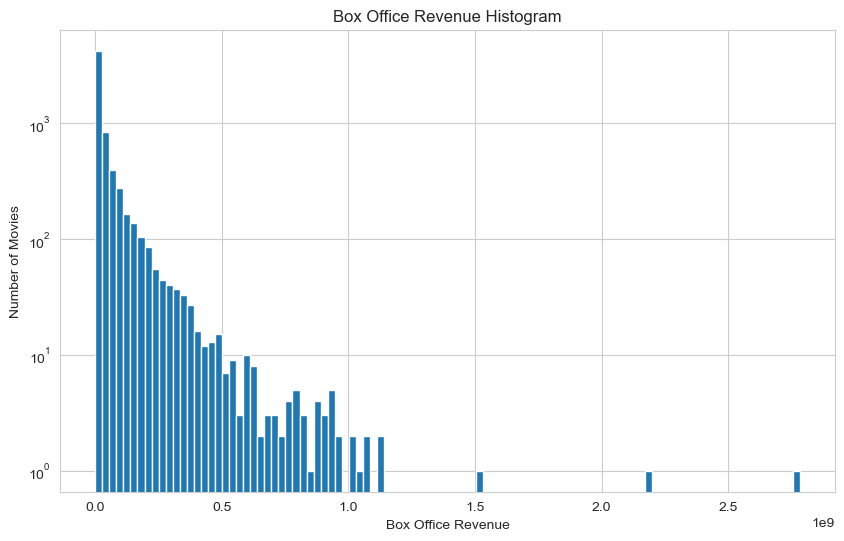

In [26]:
#plot box office revenue with a log scale
plt.figure(figsize=(10, 6))
plt.hist(movie_metadata_df['movie_box_office_revenue'], bins=100, log=True)
plt.xlabel('Box Office Revenue')
plt.ylabel('Number of Movies')
plt.title('Box Office Revenue Histogram')
plt.show()

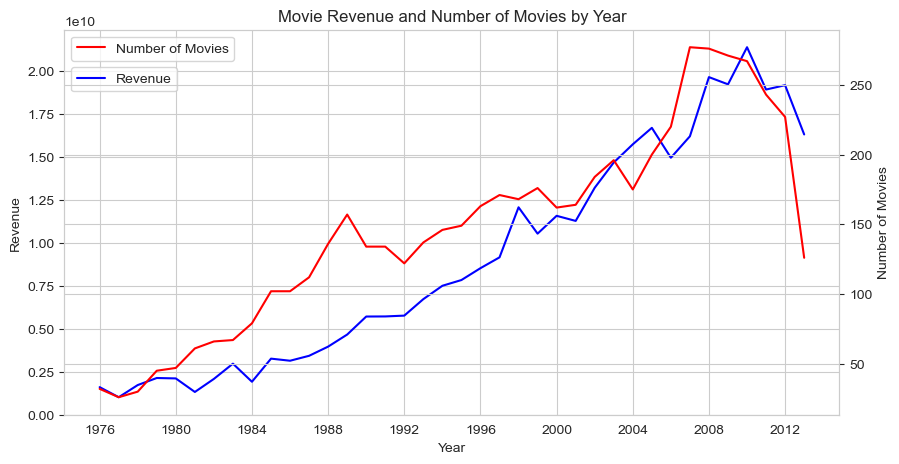

In [27]:
#aggregate movie revenue by year
movie_revenue_by_year = movie_metadata_df.groupby(pd.Grouper(key='movie_release_date', freq='Y'))['movie_box_office_revenue'].sum()
#aggregate number of movies by year ignoring movies with no revenue
movie_with_revenue = movie_metadata_df[movie_metadata_df['movie_box_office_revenue'] > 0]
movie_by_year = movie_with_revenue.groupby(pd.Grouper(key='movie_release_date', freq='Y'))['movie_box_office_revenue'].count()
#plot movie revenue by year
plt.figure(figsize=(10,5))
plt.plot(movie_revenue_by_year.loc['1975':'2012'], color='blue', label='Revenue')
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.legend(loc='upper left', bbox_to_anchor=(0, 0.92))
plt.twinx()
plt.plot(movie_by_year.loc['1975':'2012'], color='red', label='Number of Movies')
plt.ylabel('Number of Movies')
plt.title('Movie Revenue and Number of Movies by Year')
plt.legend(loc='upper left')
plt.show()

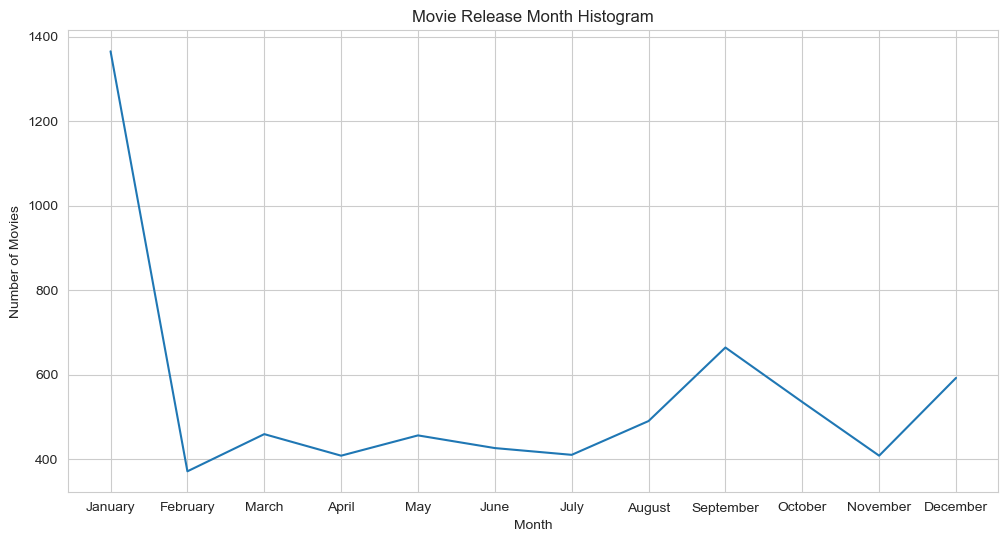

In [28]:
#movies per month ignoring movies with no revenue
movie_per_month = movie_with_revenue.groupby(movie_with_revenue['movie_release_date'].dt.strftime('%m')).count()['freebase_movie_id']
movie_per_month.index = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 
                                'November', 'December']
#plot a histogram of the months with the most movies released
plt.figure(figsize=(12, 6))
plt.plot(movie_per_month)
plt.xlabel('Month')
plt.ylabel('Number of Movies')
plt.title('Movie Release Month Histogram')
plt.show()

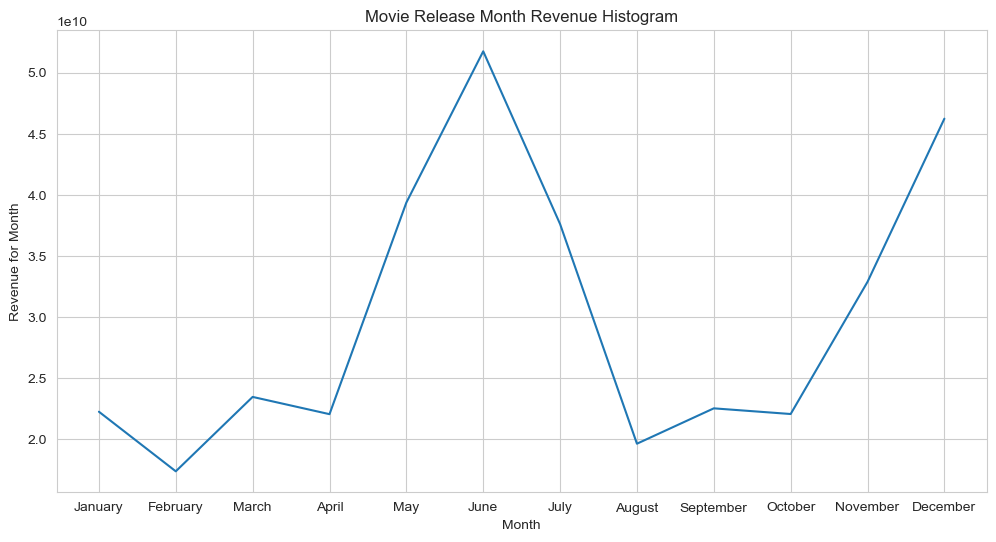

In [29]:
#aggregate movie revenue by month in 12 bins
movie_revenue_by_month = movie_metadata_df.groupby(movie_metadata_df['movie_release_date'].dt.strftime('%m'))['movie_box_office_revenue'].sum()
#change index to month names
movie_revenue_by_month.index = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 
                                'November', 'December']
#plot histogram of movie revenue by month
plt.figure(figsize=(12, 6))
plt.plot(movie_revenue_by_month)
plt.xlabel('Month')
plt.ylabel('Revenue for Month')
plt.title('Movie Release Month Revenue Histogram')
plt.show()

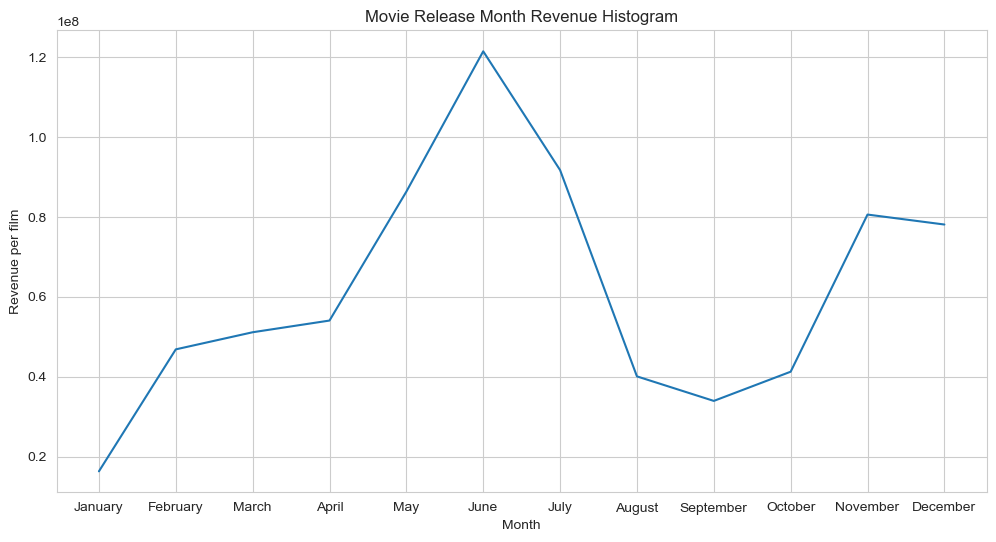

In [30]:
#plot month that are the most profitable
plt.figure(figsize=(12, 6))
plt.plot(movie_revenue_by_month/movie_per_month)
plt.xlabel('Month')
plt.ylabel('Revenue per film')
plt.title('Movie Release Month Revenue Histogram')
plt.show()

In [31]:
#5 longest movies
movie_metadata_df.sort_values(by=['movie_runtime'], ascending=False).head(5)

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,startYear
57255,2551150,/m/07mjjc,Rebound,2005-07-01,17492014.0,1003.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01z02hx"": ""Sports"", ""/m/0hqxf"": ""Family F...",2005
45085,147213,/m/012tj4,Shoah,1985-01-01,NaN,544.0,"{""/m/064_8sq"": ""French Language"", ""/m/03hkp"": ...","{""/m/0f8l9c"": ""France""}","{""/m/03g3w"": ""History"", ""/m/082gq"": ""War film""...",1985
19597,1236676,/m/04l0c9,Empire,1964-01-01,NaN,485.0,"{""/m/06ppq"": ""Silent film""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/0219x_"": ""Indi...",1964
29772,1236122,/m/04kzqz,Gettysburg,1993-01-01,10769960.0,366.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",1993
38295,2384482,/m/0785tk,Bound by Honor,1993-02-05,35000.0,330.0,"{""/m/0jzc"": ""Arabic Language"", ""/m/02h40lc"": ""...","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F...",1993


In [32]:
#5 longest movies excluding movies longer than 240 minutes (4 hours)
movie_metadata_df[movie_metadata_df['movie_runtime'] < 240].sort_values(by=['movie_runtime'], ascending=False).head(5)

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,startYear
20440,417004,/m/025w1d,The Falls,1980-01-01,NaN,239.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/06n90"": ""Science Fiction"", ""/m/0219x_"": ""...",1980
71128,24583717,/m/0807zzf,Love Exposure,2008-11-29,NaN,237.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/02l7c8"": ""Romance Film"", ""/m/02kdv5l"": ""A...",2008
46328,5883015,/m/0fbp9v,The Lost City,1935-03-06,NaN,236.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/02kdv5l...",1935
76622,770242,/m/03b1xy,Flash Gordon Conquers the Universe,1940-03-09,NaN,234.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/03k9fj"": ""...",1940
37834,2804704,/m/083skw,Gone with the Wind,1939-12-15,400000000.0,234.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/060__y"": ""Film adaptation"", ""/m/04xvh5"": ...",1939


In [68]:
movie_runtime_rating_df = movies_metadata_ratings[['movie_runtime','averageRating']]
filtered_movie_runtime_rating_df = movie_runtime_rating_df[movie_runtime_rating_df['movie_runtime'] < 400]
movie_runtime_rating_df.head()

,movie_runtime,averageRating
0,98.0,4.9
3,106.0,5.9
8,137.0,7.5
9,139.0,7.8
13,82.0,6.1


# **Step: Movie runtime and avverage rating**

Text(0.5, 0.98, 'Average Rating per movie movie runtime ')

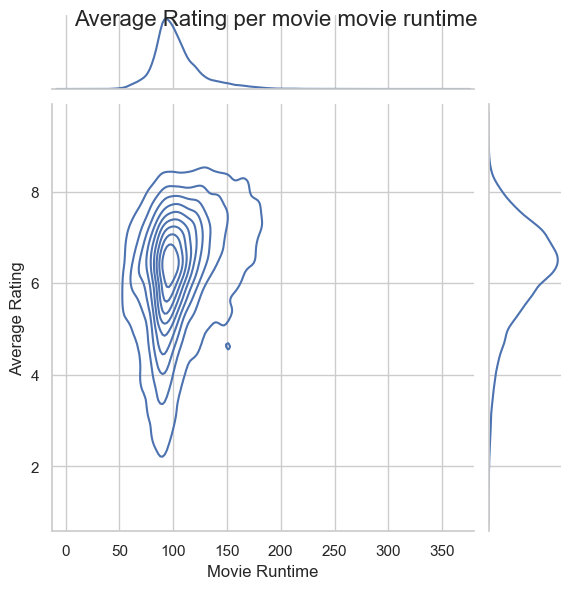

In [80]:
sns.set(style="whitegrid")  
g = sns.jointplot(x=filtered_movie_runtime_rating_df['movie_runtime'], y=filtered_movie_runtime_rating_df['averageRating'], kind='kde', height=6)

# Set labels and title
g.set_axis_labels('Movie Runtime', 'Average Rating', fontsize=12)
g.fig.suptitle('Average Rating per movie movie runtime ', fontsize=16)

In [81]:
correlation_coefficient, p_value = stats.pearsonr(filtered_movie_runtime_rating_df['movie_runtime'], filtered_movie_runtime_rating_df['averageRating'])
print(f"Correlation Coefficient: {correlation_coefficient}")
print(f"P-Value: {p_value}")


Correlation Coefficient: 0.2566673074667025
P-Value: 7.922684158864968e-287


## **Interpretation**

The obtained p-value indicate that the correlation coeficient observed is statisticlly significant, meaning that is almost impossible to observe such result by random chance.
The correlation coefficient 0.257 indicate a small positif linear relationship meaning that when the movie runtime increases, there is a tendency for the average rating to also increase slightly. However, our correlation coefficient is relatively small, thus it is indicating that movie runtime alone does not explain a large portion of the variability in average ratings.

The density of contours around the center suggests that a majority of movies have a runtime between approximately 90 to 150 minutes and these movies tend to have a wide range of ratings. However, there is a noticeable concentration of higher ratings (between 6 and 8 on average) for movies that fall within this runtime range. The peak of the distribution for average ratings also seems to correspond to a movie runtime of around 100 to 120 minutes, indicating that this duration is optimal for achieving higher ratings.

There are fewer movies with short or very long runtimes.The contour lines spread wider at the extremes, particularly for the longer runtime end, which suggests more variability in the ratings of movies with longer runtimes. This could indicate that while longer movies have the potential to achieve high ratings, it is less consistent.

Movie runtime is an important parameter because it needs to be sufficient enough to develop the plot and characters correctly, but not so long that it risks losing the audience's attention. The sweet spot indicated by the graph suggests that viewers may prefer movies that are long enough to be engaging and complete but short enough to maintain attention and interest throughout.


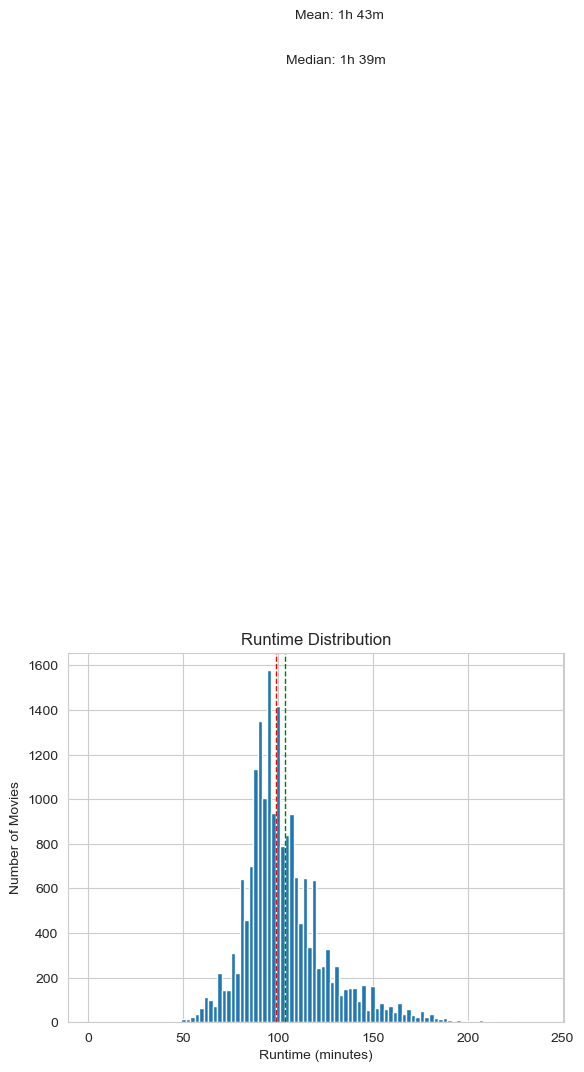

In [33]:
#plot runtime distribution with median and mean
plt.hist(movie_metadata_df[movie_metadata_df['movie_runtime'] < 240]['movie_runtime'], bins=100)
plt.axvline(movie_metadata_df['movie_runtime'].median(), color='red', linestyle='dashed', linewidth=1)
plt.text(movie_metadata_df['movie_runtime'].median() + 5, 4300, 'Median: ' + str(int(movie_metadata_df['movie_runtime'].median()/60)) + 'h ' + str(int(movie_metadata_df['movie_runtime'].median()%60)) + 'm')
plt.axvline(movie_metadata_df['movie_runtime'].mean(), color='green', linestyle='dashed', linewidth=1)
plt.text(movie_metadata_df['movie_runtime'].mean() + 5, 4500, 'Mean: ' + str(int(movie_metadata_df['movie_runtime'].mean()/60)) + 'h ' + str(int(movie_metadata_df['movie_runtime'].mean()%60)) + 'm')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Number of Movies')
plt.title('Runtime Distribution')
plt.show()

In [34]:
#5 shortest movies
movie_metadata_df.sort_values(by=['movie_runtime'], ascending=True).head(5)

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,startYear
54396,2322506,/m/073qxn,Fantastic Planet,1973-12-01,NaN,1.25,"{""/m/064_8sq"": ""French Language""}","{""/m/0f8l9c"": ""France"", ""/m/01mjq"": ""Czech Rep...","{""/m/02hmvc"": ""Short Film"", ""/m/06n90"": ""Scien...",1973
11762,33994214,/m/0hr6p_4,The King of Pigs,2011-10-08,NaN,1.50,{},"{""/m/06qd3"": ""South Korea""}","{""/m/02hmvc"": ""Short Film"", ""/m/0hcr"": ""Animat...",2011
56639,35025043,/m/0j63_8s,I Love You,2007-01-01,NaN,3.00,{},{},"{""/m/02hmvc"": ""Short Film""}",2007
45815,22816098,/m/0641r9w,Double Identity,2009-01-01,NaN,4.00,{},"{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/02wtdps"": ""Crime...",2009
78438,5467528,/m/0dn5gt,Our Relations,1936-10-30,NaN,7.00,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/0hj3mz5"": ""Com...",1936


In [35]:
#extract the actor ethnicity into a Series from the character metadata removing duplicates
actor_ethnicity_series = character_metadata_df["actor_ethnicity"].drop_duplicates().dropna().reset_index(drop=True)
actor_ethnicity_series.head(10)

0    /m/044038p
1       /m/0x67
2     /m/064b9n
3    /m/0dryh9k
4     /m/048sp5
5     /m/04mvp8
6     /m/0bzkm2
7    /m/02p1pl6
8    /m/0bjbszh
9     /m/0ffkb4
Name: actor_ethnicity, dtype: object

In [36]:
def get_wikidata_id(freebase_id):
  sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
  query = f"""
  SELECT ?article ?label
  WHERE 
  {{
    ?article schema:about ?item;
        schema:isPartOf <https://en.wikipedia.org/> .
    ?item wdt:P646 "{freebase_id}";
          rdfs:label ?label.
    FILTER(LANG(?label) = "en") # Optional: Filter by English labels
  }}
  """
  sparql.setQuery(query)
  sparql.setReturnFormat(JSON)
  
  try:
      results = sparql.query().convert()
      if 'results' in results and 'bindings' in results['results'] and len(results['results']['bindings']) > 0:
          return results['results']['bindings'][0]['label']['value']
  except Exception as e:
      print(f"Error: {e}")
      time.sleep(20)
      return get_wikidata_id(freebase_id)
  
  return None

In [37]:
#create a dataframe from the results of the sparql query from every element in actor_ethnicity_series
transformed_values = [get_wikidata_id(value) for value in actor_ethnicity_series]

Error: HTTP Error 429: Too Many Requests
Error: HTTP Error 429: Too Many Requests
Error: HTTP Error 429: Too Many Requests
Error: HTTP Error 429: Too Many Requests
Error: HTTP Error 429: Too Many Requests
Error: HTTP Error 429: Too Many Requests


In [38]:
data = {'ethnicity_id': actor_ethnicity_series, 'ethnicity_name': transformed_values}
df = pd.DataFrame(data)
df.head(10)

,ethnicity_id,ethnicity_name
0,/m/044038p,None
1,/m/0x67,African Americans
2,/m/064b9n,Omaha people
3,/m/0dryh9k,Indian person
4,/m/048sp5,Ezhava
5,/m/04mvp8,Malayali
6,/m/0bzkm2,Taiwanese
7,/m/02p1pl6,None
8,/m/0bjbszh,None
9,/m/0ffkb4,Lithuanian American


In [41]:
#characters that have been played by multiple actors
character_metadata_df[character_metadata_df['character_name'].duplicated(keep=False)].sort_values(by=['character_name'])

,wiki_movie_id,freebase_movie_id,movie_release_date,character_name,actor_date_of_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id
172072,747689,/m/037_84,1979-03-14,'3-5-0-0' Soloist,1950-06-05,M,NaN,NaN,Ronnie Dyson,28.0,/m/0gy_y5r,/m/0h5rdn3,/m/01p27qd
172057,747689,/m/037_84,1979-03-14,'3-5-0-0' Soloist,1945-10-29,F,NaN,/m/0x67,Melba Moore,33.0,/m/0cg6hqj,/m/0h5rdnt,/m/08rgr4
38685,673694,/m/031tc2,1988-08-10,'Jose' Chavez y Chavez,1962-02-17,M,1.85,/m/03295l,Lou Diamond Phillips,26.0,/m/02vcg9t,/m/0h2k5dk,/m/031zkw
29510,675213,/m/031zk3,1990-08-01,'Jose' Chavez y Chavez,1962-02-17,M,1.85,/m/03295l,Lou Diamond Phillips,28.0,/m/02vc4lz,/m/0h2k5dk,/m/031zkw
177246,28370864,/m/0crfcdl,2011-08-12,'Juicy' Judy Gonzalez,1977-03-26,F,1.73,NaN,Bianca Kajlich,34.0,/m/0gvd8fd,/m/0cgm75g,/m/0dlbpj
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450567,22330502,/m/05sync6,1931-01-31,NaN,1889-07-15,F,NaN,NaN,Marjorie Rambeau,NaN,/m/05tg4vt,NaN,/m/079q2l
450584,24997872,/m/09g6klx,2010-05-07,NaN,1972-09-09,M,NaN,/m/01rv7x,Riyaz Khan,37.0,/m/0h888_7,NaN,/m/04645zm
450588,24997872,/m/09g6klx,2010-05-07,NaN,1944-08-01,M,NaN,/m/01rv7x,Delhi Ganesh,65.0,/m/0h6krrl,NaN,/m/04cw5sb
450589,24997872,/m/09g6klx,2010-05-07,NaN,1948-05-22,M,NaN,/m/04mvp8,Nedumudi Venu,61.0,/m/0h7yl4y,NaN,/m/02hkw6


# 4) LARGE REVENUE COORELATION WITH THE IMDB RATINGS

In [42]:
sns.jointplot(x=movies_ratings['averageRating'], y=np.log10(movies_ratings['movie_box_office_revenue']), kind="hex")

NameError: name 'movies_ratings' is not defined

In [43]:
# correlation between the average rating and the box office revenue
movies_ratings['averageRating'].corr(movies_ratings['movie_box_office_revenue'])


NameError: name 'movies_ratings' is not defined

# 5) Linking events to movies 